In [3]:
from typing import List
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
from pathlib import Path

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 20})

In [7]:
MAIN_DIR = Path("../../../../")

plot_dir = MAIN_DIR / "plots/BiasTest/24Apr8NonresVBF"
plot_dir.mkdir(exist_ok=True, parents=True)

In [11]:
resonant = False

if not resonant:
    cards_dir = "24Apr4VBFBDTScan/k2v0/txbb_HP_bdt_0.999_lepton_veto_Hbb"
    r_bounds = [-15, 15]
    biases = [1.0]
    samples = ["k2v0"]
else:
    cards_dir = "23Sep22Scale100_bgs_only_scaleqcdsqrt"
    bias_dir = "23Sep22"

    # r_bounds = [-1, 20]
    r_bounds = [-15, 15]

    samples = [
        # "NMSSM_XToYHTo2W2BTo4Q2B_MX-1200_MY-190",
        "NMSSM_XToYHTo2W2BTo4Q2B_MX-2000_MY-125",
        # "NMSSM_XToYHTo2W2BTo4Q2B_MX-3000_MY-250",
    ]

    biases = [0.0, 0.15, 0.3, 1.0]

In [12]:
r_dict = {}

for sample in samples:
    if sample not in r_dict:
        r_dict[sample] = {}

    for bias in biases:
        if bias in r_dict[sample]:
            continue

        print(sample, bias)
        if not resonant:
            file_name = f"/uscms/home/rkansal/hhcombine/cards/{cards_dir}/higgsCombinebias1.FitDiagnostics.mH125.42.root"
        else:
            file_name = f"/uscms/home/rkansal/hhcombine/cards/biastests/{cards_dir}/{sample}/bias/{bias_dir}/higgsCombinebias{bias}.FitDiagnostics.mH125.*.root"
        file = uproot.concatenate(file_name)

        r = np.array(file.limit)[::4]
        neg_lim = np.array(file.limit)[1::4]
        pos_lim = np.array(file.limit)[2::4]
        r_negerr = r - neg_lim
        r_poserr = pos_lim - r
        reldiff = r - bias
        reldiff[reldiff < 0] = (reldiff / r_poserr)[reldiff < 0]
        reldiff[reldiff > 0] = (reldiff / r_negerr)[reldiff > 0]

        r_dict[sample][bias] = {
            "r": r,
            "reldiff": reldiff,
            "neg_lim": neg_lim,
            "pos_lim": pos_lim,
        }

k2v0 1.0


In [17]:
# checking in how many fits the ±r values are at the parameter boundary i.e. they are unreliable
for sample in samples:
    print(sample)
    for i, bias in enumerate(biases):
        num_toys = len(r_dict[sample][bias]["r"])

        print(
            f"For r = {bias}, # of successful fits: = {num_toys}, {np.sum(r_dict[sample][bias]['neg_lim'] == r_bounds[0]) / num_toys * 100:.0f}% of these with r- = {r_bounds[0]}, {np.sum(r_dict[sample][bias]['pos_lim'] == r_bounds[1]) / num_toys * 100 :.0f}% with r+ = {r_bounds[1]}"
        )

k2v0
For r = 1.0, # of successful fits: = 96, 9% of these with r- = -15, 11% with r+ = 15


In [14]:
# checking in how many fits the ±r values are at the parameter boundary AND that side is the one we care about
for sample in samples:
    print(sample)
    for i, bias in enumerate(biases):
        num_toys = len(r_dict[sample][bias]["r"])
        r_lims_bounds = (
            (r_dict[sample][bias]["reldiff"] < 0)
            * (np.isclose(r_dict[sample][bias]["pos_lim"], r_bounds[1]))
        ) + (
            (r_dict[sample][bias]["reldiff"] > 0)
            * (np.isclose(r_dict[sample][bias]["neg_lim"], r_bounds[0]))
        )

        r_lims_wrong = r_dict[sample][bias]["pos_lim"] == r_dict[sample][bias]["neg_lim"]

        tot_pfail = np.sum(r_lims_bounds + r_lims_wrong)

        print(
            f"For r = {bias}, # of successful fits: = {num_toys}, {tot_pfail / num_toys * 100:.0f}% of these with r-lim at boundary"
        )

k2v0
For r = 1.0, # of successful fits: = 96, 10% of these with r-lim at boundary


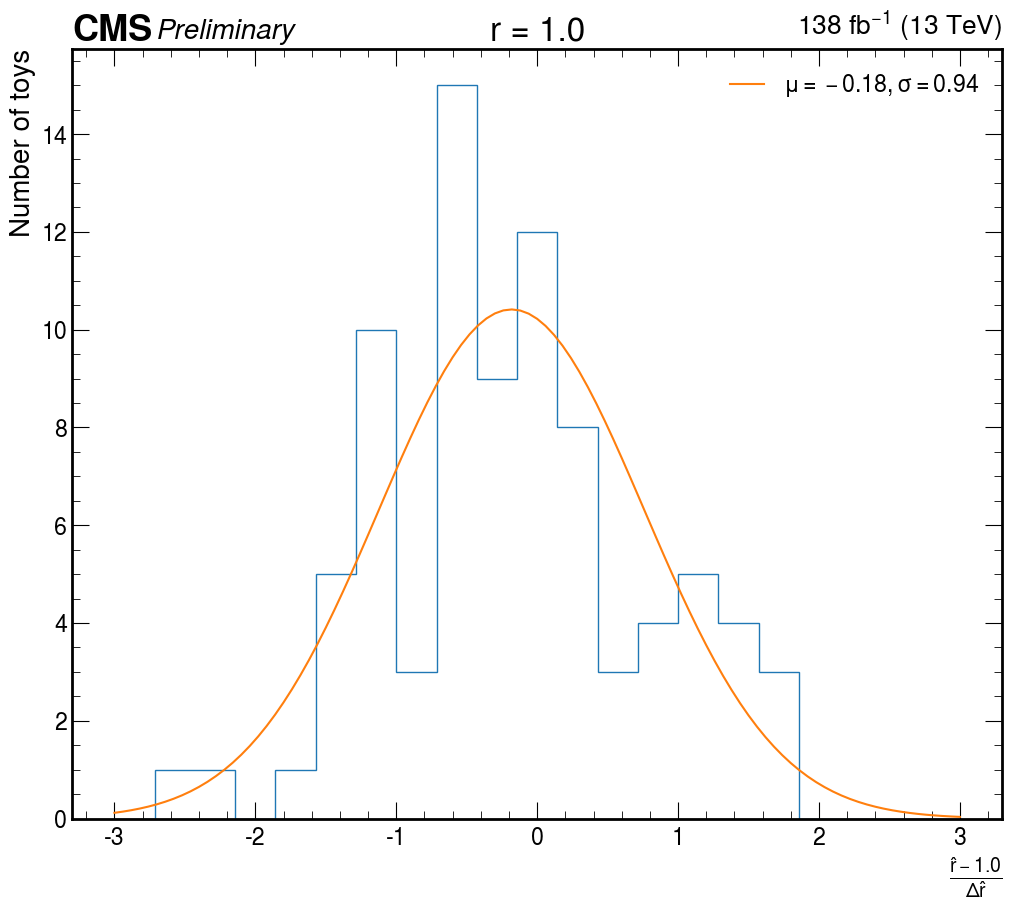

In [16]:
from scipy import stats

xrange = 3
bins = 21
x = np.linspace(-xrange, xrange, 101)

for sample in samples:
    # if sample != "NMSSM_XToYHTo2W2BTo4Q2B_MX-3000_MY-250":
    #     continue
    fig, axs = plt.subplots(len(biases), 1, figsize=(12, len(biases) * 10))

    for i, bias in enumerate(biases):
        # fit_fail = r_dict[sample][bias]["pos_lim"] == 40
        # fit_fail = r_dict[sample][bias]['pos_lim'] == 2000000

        r_lims_bounds = (
            (r_dict[sample][bias]["reldiff"] < 0)
            * (np.isclose(r_dict[sample][bias]["pos_lim"], r_bounds[1]))
        ) + (
            (r_dict[sample][bias]["reldiff"] > 0)
            * (np.isclose(r_dict[sample][bias]["neg_lim"], r_bounds[0]))
        )

        r_lims_same = r_dict[sample][bias]["pos_lim"] == r_dict[sample][bias]["neg_lim"]

        fit_fail = r_lims_bounds + r_lims_same

        r = r_dict[sample][bias]["r"][~fit_fail]
        reldiff = r_dict[sample][bias]["reldiff"][~fit_fail]
        reldiff = reldiff[(reldiff > -xrange) * (reldiff < xrange)]

        mu, sigma = np.mean(reldiff), np.std(reldiff)

        ax = axs[i] if len(biases) > 1 else axs

        ax.hist(reldiff, np.linspace(-xrange, xrange, bins + 1), histtype="step")
        ax.plot(
            x,
            # scale by bin width
            stats.norm.pdf(x, loc=mu, scale=sigma) * len(r) * (2 * xrange / bins),
            label=rf"$\mu = {mu:.2f}, \sigma = {sigma:.2f}$",
        )
        ax.set_xlabel(rf"$\frac{{\hat{{r}} - {bias}}}{{\Delta \hat r}}$")
        ax.set_ylabel("Number of toys")
        ax.set_title(f"r = {bias}")
        ax.legend()

        hep.cms.label(
            "Preliminary",
            ax=ax,
            data=True,
            lumi=138,
            year=None,
        )

    plt.savefig(f"{plot_dir}/{sample}.pdf", bbox_inches="tight")
    plt.show()

    # break

In [ ]:
sample = "NMSSM_XToYHTo2W2BTo4Q2B_MX-2000_MY-125"
bias = 0.0

r_lims_bounds = (
    (r_dict[sample][bias]["reldiff"] < 0)
    * (np.isclose(r_dict[sample][bias]["pos_lim"], r_bounds[1]))
) + (
    (r_dict[sample][bias]["reldiff"] > 0)
    * (np.isclose(r_dict[sample][bias]["neg_lim"], r_bounds[0]))
)

r_lims_same = r_dict[sample][bias]["pos_lim"] == r_dict[sample][bias]["neg_lim"]

fit_fail = r_lims_bounds + r_lims_same

preldiff = r_dict[sample][bias]["reldiff"][~fit_fail]
pposlim = r_dict[sample][bias]["pos_lim"][~fit_fail]
pneglim = r_dict[sample][bias]["neg_lim"][~fit_fail]
pr = r_dict[sample][bias]["r"][~fit_fail]

select = (preldiff >= -0.7) * (preldiff <= -0.6)

pos_lim = pposlim[select]
pos_lim

In [ ]:
pr[select]

In [ ]:
preldiff[select]

In [ ]:
plt.hist(r_dict[sample][bias]["pos_lim"])

In [ ]:
plt.hist(r_dict[sample][bias]["neg_lim"])

In [ ]:
r = pr[select]
r

In [ ]:
plt.hist(r_dict[sample][bias]["r"])

In [ ]:
neg_lim = pneglim[select]
neg_lim

In [ ]:
plt.hist(neg_lim)

In [ ]:
from ipywidgets import interact, FloatSlider


def phist(cut):
    plt.hist(pneglim[preldiff > cut], np.linspace(-0.5, 0.5, 21), histtype="step")


interact(phist, cut=FloatSlider(min=-1, max=5, step=0.1))

In [ ]:
reldiff = r_dict[sample][bias]["reldiff"][~fit_fail][select]
reldiff